In [5]:
import pandas as pd
import numpy as np
import sklearn
import json
import matplotlib.pyplot as plot
from wordcloud import WordCloud
%matplotlib inline

## Read in the user metadata file

In [6]:
user_metadata_file = 'user_metadata_latest_with_friends.json'
with open(user_metadata_file) as f:
    users = json.load(f)
    user_info= pd.DataFrame(users)

Add columns for follows_sg, follows_professional_sg, and follows_thinspo

In [7]:
user_info['follows_sg'] = None
user_info['follows_professional_sg'] = None
user_info['follows_thinspo'] = None
user_info['is_anorexia_recovery'] = None

In [8]:
user_info.head()

,created_at,description,favourites_count,followers_count,friends,friends_count,id,lang,listed_count,location,...,profile_location,screen_name,statuses_count,time_zone,utc_offset,verified,follows_sg,follows_professional_sg,follows_thinspo,is_anorexia_recovery
0,2013-01-04 14:14:01,recovering from anorexia. inpatient X1 .life i...,63,1842,"[{'id': 1322319715, 'screen_name': 'UnreveaISe...",536,1060558130,en,18,Wonderland,...,None,BrokenPurge,18326,None,None,False,None,None,None,None
1,2018-07-13 18:37:04,Tweeting all things MH & positive thoughts whi...,41,50,NaN,213,1017840348083650560,en,0,,...,None,flyingf28327022,159,None,None,False,None,None,None,None
2,2017-07-17 17:41:33,Jumping on the bandwagon of 'tweet what you ea...,31,32,"[{'id': 830185249426522112, 'screen_name': 're...",185,887004356075286528,en,1,"South West, England",...,None,queenofoats,22,None,None,False,None,None,None,None
3,2016-06-06 11:15:49,New TV series seeks 16-19yr olds suffering fro...,9,77,"[{'id': 461686577, 'screen_name': 'myselfandhe...",256,739777811964153856,en-gb,0,"London, England",...,None,NewEDProg,221,None,None,False,None,None,None,None
4,2010-02-01 18:36:29,A recovering anorexic simultaneously trying to...,0,4397,"[{'id': 159020753, 'screen_name': 'jamezattard...",5661,110487555,en,108,London,...,None,msjoannacake,3245,None,None,False,None,None,None,None


## Gather information about the number of support groups

In [9]:
support_groups = pd.read_csv('supportgroup.csv', header=1)
print(len(support_groups))
support_groups.head()

35


,screen_name,is_thinspo,is_anorexia_recovery,professional_sg,sg,follows_thinspo,Notes
0,cheers_forana,TRUE,False,NaN,NaN,TRUE,NaN
1,lifeoverAna,FALSE,True,"Silencing_ED,EatingRecovery,loveyourbody,EDCar...","angelaegambrel,ichosetolive,HopefulRecovery,An...",FALSE,NaN
2,BrokenPurge,FALSE,True,"AnorexiaDaily,Spreading_L0ve,SelfHarmWIILEnd,A...","scalesR4fish,StandStr0ng,DyingDaisy_,AwareOfSe...",TRUE,NaN
3,xbertyx,FALSE,True,"ProjectBuddy,AgainstSuicide",EndThePain_,TRUE,Fitness enthu
4,flyingf28327022,NaN,NaN,NaN,NaN,NaN,Private user


Only consider a user as following a support group if they follow > 2 support groups

In [10]:
professional_sg_set = set()
sg_set = set()

THRESHOLD = 2

for i in range(len(support_groups)):
    screen_name = support_groups.loc[i, 'screen_name']
    
    # can be empty
    idx = user_info.index[user_info['screen_name'] == screen_name]
    
    # get professional support groups
    professional_sg = support_groups.loc[i, 'professional_sg']
    if not pd.isnull(professional_sg) and professional_sg is not '-':
        sgs = list(map(lambda x: x.lower(), professional_sg.split(',')))
        # Classify user as following professional SG if they follow >= THRESHOLD professional SG's
        if not idx.empty:
            user_info.at[idx, 'follows_professional_sg'] = len(sgs) >= THRESHOLD
        professional_sg_set.update(sgs)
    
    # get non-professional support groups
    sg = support_groups.loc[i, 'sg']
    if not pd.isnull(sg) and sg is not '-':
        sgs = list(map(lambda x: x.lower(), sg.split(',')))
        # Classify user as following SG if they follow >= THRESHOLD SG's
        if not idx.empty:
            user_info.at[idx, 'follows_sg'] = len(sgs) >= THRESHOLD
        sg_set.update(sgs)
        
    is_anorexia_recovery = support_groups.loc[i, 'is_anorexia_recovery']
    if not pd.isnull(sg) and sg is not '-':
        if not idx.empty:
            user_info.at[idx, 'is_anorexia_recovery'] = is_anorexia_recovery == True
    
    follows_thinspo = support_groups.loc[i, 'follows_thinspo']
    if not pd.isnull(sg) and sg is not '-':
        if not idx.empty:
            user_info.at[idx, 'follows_thinspo'] = follows_thinspo == 'TRUE'
        sg_set.update(sgs)

print("# professional support groups: {}".format(len(professional_sg_set)))
print("# non-professional support_groups: {}".format(len(sg_set)))

# professional support groups: 102
# non-professional support_groups: 106


Classify the users in the users_info data frame as following professional support groups, non-professional support groups, or neither

Drop the rows that have protected twitter accounts

In [11]:
user_info = user_info[user_info.follows_sg.notnull()]

In [12]:
# NOT REALLY USED RIGHT NOW
from TweetPreprocessor import TweetPreprocessor

def get_support_groups_from_list(friend):
    support_groups = []
    for follower in followers:
        description, verified = TweetPreprocessor.pipeline(friend['description'].lower()), friend['verified']
        print(description)
    return support_groups

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rvsandeep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read in Twitter users' friends

In [13]:
cols = ['description', 'verified', 'friend_id', 'associated_screen_name']
rows = []

num_users = user_info.shape[0]

for i in range(num_users):
    friends = user_info.iloc[i].friends
    screen_name = user_info.iloc[i].screen_name
    if isinstance(friends, list):
        print("{} has {} friends".format(screen_name, len(friends)))
        for friend in friends:
            # only want english speaking
            if 'en' in friend['lang']:
                description, verified = TweetPreprocessor.pipeline(friend['description'].lower()), friend['verified']
                rows.append([description, verified, friend['id'], screen_name])
            
followers_df = pd.DataFrame(rows)
followers_df.columns = cols
print("\nFound {} friends".format(followers_df.shape[0]))
followers_df.head()

BrokenPurge has 533 friends
queenofoats has 183 friends
elamame_bean has 74 friends
xbertyx has 1151 friends
AshleyVargas731 has 87 friends
lifeoverAna has 35 friends
AdriennesAngels has 177 friends
RealityTweeter has 305 friends
claire_santucci has 552 friends
madison_summer has 201 friends
lifeoverAna has 35 friends
BrokenPurge has 533 friends
xbertyx has 1151 friends
RealityTweeter has 305 friends
AshleyVargas731 has 87 friends
recover_me143 has 9 friends
health_turtle has 916 friends
madison_summer has 201 friends
Jenny_MT has 328 friends
elamame_bean has 74 friends
emmyrexia has 6 friends
belle_va has 1359 friends
edfree_chelsey has 56 friends
AnaSurvivor has 106 friends
queenofoats has 183 friends
claire_santucci has 552 friends
AdriennesAngels has 177 friends

Found 8971 friends


,description,verified,friend_id,associated_screen_name
0,unrevealed secrets conspiracies facts from all...,False,1322319715,BrokenPurge
1,gw,False,803474744234352641,BrokenPurge
2,scales are only for fish is a campaign staed b...,False,3410847515,BrokenPurge
3,multi passionate yet easily distracted optimis...,False,152468842,BrokenPurge
4,thoughts from the shower usually taken from rs...,False,487736815,BrokenPurge


In [45]:
deduplicated_followers_df = followers_df.drop_duplicates(subset='friend_id')

In [46]:
np.unique(deduplicated_followers_df.friend_id, return_counts=True)

(array([             30973,              60273,             621543, ...,
        931925733026484225, 945698284714250240, 977236062182535168]),
 array([1, 1, 1, ..., 1, 1, 1]))

Exploratory analysis on using unsupervised learning to classify Twitter users' friends with n_clusters = 3

In [71]:
deduplicated_followers_df = pd.DataFrame(followers_df.drop_duplicates(subset='friend_id'))
deduplicated_followers_df = deduplicated_followers_df.reset_index(drop=True)
# Try some unsupervised learning to classify the users based on description
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
n_clusters = 5

vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                 min_df=2, stop_words='english')
X = vectorizer.fit_transform(deduplicated_followers_df.description)

km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
labels = km.fit_predict(X)

classes, counts = np.unique(labels, return_counts=True)
for i in range(len(classes)):
    print("Class {}: {} # of members".format(classes[i], counts[i]))

assert(len(labels) == deduplicated_followers_df.shape[0])
for i in range(deduplicated_followers_df.shape[0]):
    deduplicated_followers_df.loc[i, 'class'] = labels[i]
deduplicated_followers_df[['description', 'class']]

for i in range(n_clusters):
    class_df = deduplicated_followers_df[deduplicated_followers_df['class'] == i]
    print("=" * 20, "Class number {}: ({} users)".format(i, class_df.shape[0]), "=" * 20)
    print(class_df[['description']].head())

Class 0: 243 # of members
Class 1: 4251 # of members
Class 2: 179 # of members
Class 3: 285 # of members
Class 4: 441 # of members
==================== Class number 0: (243 users) ====================
                                          description
1                                                  gw
26                                         cw fat ugw
31  depressedself hateharmanxietyana venting accou...
92  lost my sanity trying to stay sane bingepurge ...
98  i try to be more mysterious than i really am b...
==================== Class number 1: (4251 users) ====================
                                         description
0  unrevealed secrets conspiracies facts from all...
3  multi passionate yet easily distracted optimis...
4  thoughts from the shower usually taken from rs...
5  i ruined myself for a lot of people that were ...
7  doctor from the university of cambridge now wo...
==================== Class number 2: (179 users) ====================
                

In [72]:
deduplicated_followers_df.head()

,description,verified,friend_id,associated_screen_name,class
0,unrevealed secrets conspiracies facts from all...,False,1322319715,BrokenPurge,1.0
1,gw,False,803474744234352641,BrokenPurge,0.0
2,scales are only for fish is a campaign staed b...,False,3410847515,BrokenPurge,4.0
3,multi passionate yet easily distracted optimis...,False,152468842,BrokenPurge,1.0
4,thoughts from the shower usually taken from rs...,False,487736815,BrokenPurge,1.0


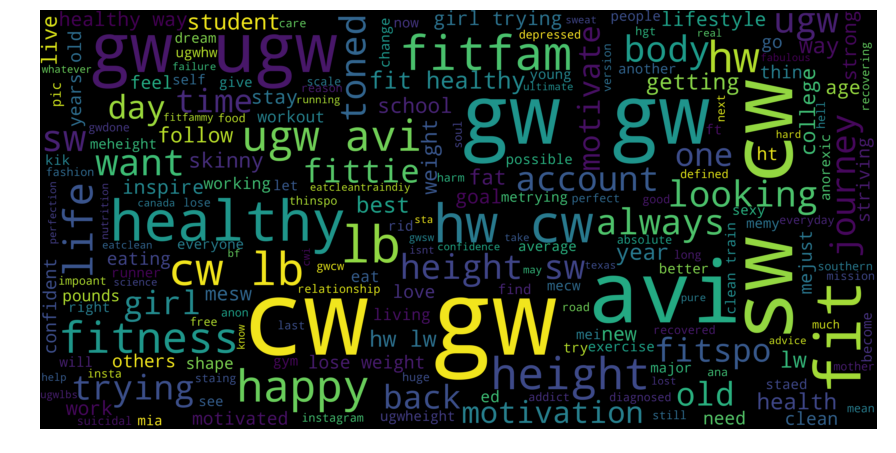

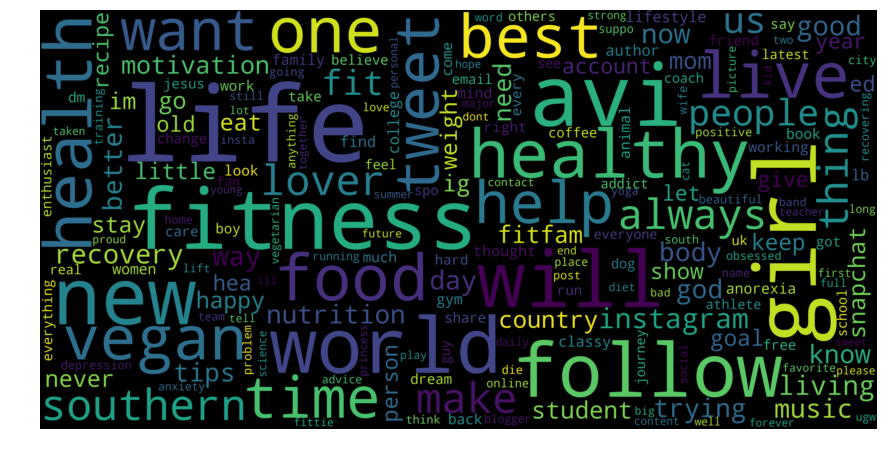

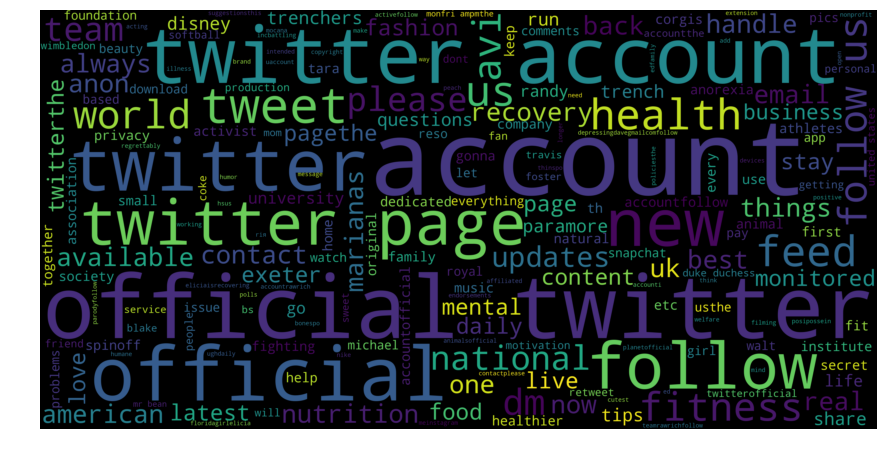

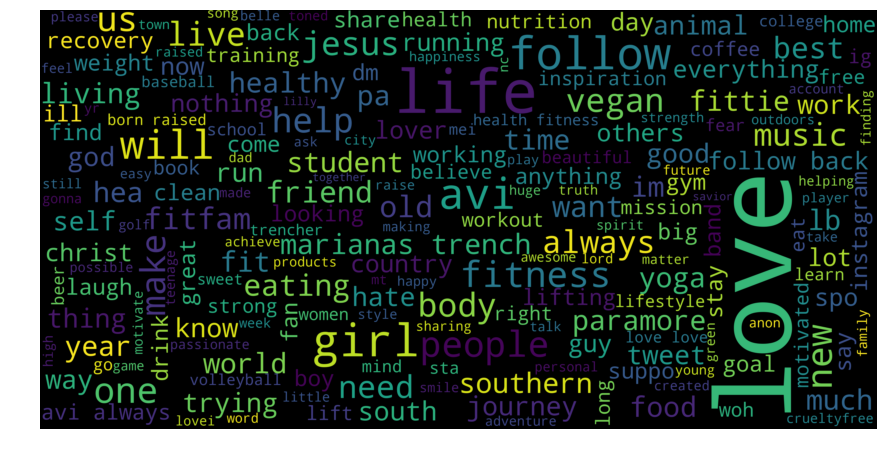

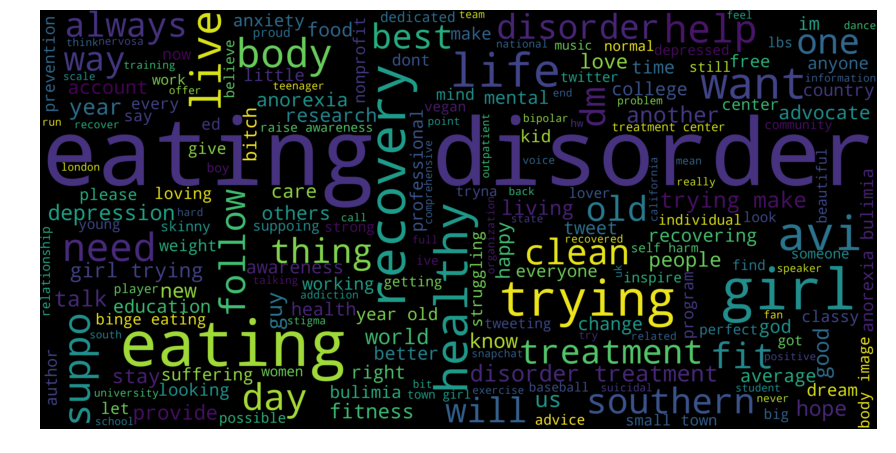

In [73]:
classes = np.unique(deduplicated_followers_df['class'])
for i in classes:
    wordcloud_string = ''
    class_foll_desc = deduplicated_followers_df[deduplicated_followers_df['class'] == i]
    for i in range(class_foll_desc.shape[0]):
        wordcloud_string += class_foll_desc.iloc[i].description

    wordcloud = WordCloud(width=4000, height=2000,max_font_size=500).generate(wordcloud_string)
    plot.figure(figsize=(15,12))
    plot.imshow(wordcloud, interpolation="bilinear")
    plot.axis("off")
    plot.show()


In [12]:
dump = user_info[['description','statuses_count', 'screen_name', 'friends']]

In [273]:
dump

,description,statuses_count,screen_name,friends
0,recovering from anorexia. inpatient X1 .life i...,18326,BrokenPurge,"[{'id': 1322319715, 'screen_name': 'UnreveaISe..."
2,Jumping on the bandwagon of 'tweet what you ea...,22,queenofoats,"[{'id': 830185249426522112, 'screen_name': 're..."
5,"recovery from anorexia nervosa,depression and ...",17,elamame_bean,"[{'id': 1040219695, 'screen_name': 'the_golden..."
6,"Buddhist, recovering anorexic, 18yr old girl l...",12279,xbertyx,"[{'id': 1337194476, 'screen_name': 'ProjectBud..."
7,Recovering from Anorexia. Love God. Love my hu...,80,AshleyVargas731,"[{'id': 2247880584, 'screen_name': 'CREDNetwor..."
8,22. Depression. Anxiey. BDD. Recovering Anorex...,73,lifeoverAna,"[{'id': 634499903, 'screen_name': 'KeepCaImTwe..."
9,I am a recovering anorexic (by the grace of co...,35,AdriennesAngels,"[{'id': 75087970, 'screen_name': 'CalleyMcGuir..."
13,"Journey through recovery from anorexia, depres...",2007,RealityTweeter,"[{'id': 18236230, 'screen_name': 'JeffreeStar'..."
14,Battling Anorexia and other MH problems🌈 ‘Sto...,2217,claire_santucci,"[{'id': 1258202948, 'screen_name': 'hermy1G', ..."
15,Recovering from Anorexia; Here for anyone who ...,91,madison_summer,"[{'id': 1108166724, 'screen_name': 'SkinnyPlea..."


# Reading in Tweets file

In [229]:
tweet_file = 'user_tweets_latest.jsonl'
tweet_train = []
with open(tweet_file) as fp:
    for line in fp.readlines():
        tweet_train.append(json.loads(line))

In [230]:
tweets = pd.DataFrame(tweet_train)

In [233]:
tweets['tweeter_screen_name'].unique()

array(['HanBaNannz', 'elamame_bean', 'msjoannacake', 'cheers_forana',
       'AdriennesAngels', 'xbertyx', 'queenofoats', 'NewEDProg',
       'BrokenPurge', 'recover_me143', 'madison_summer', 'lifeoverAna',
       'health_turtle', 'Jenny_MT', 'stuckinbetween_', 'emmyrexia',
       'belle_va', 'BeSkinny_', 'Silencing_ED', 'claire_santucci',
       'edfree_chelsey', 'AnaSurvivor', 'angelaegambrel', 'Tryingforfit',
       'RealityTweeter', 'eatdisorderhelp', 'AshleyVargas731',
       'FitspoKickBoxer'], dtype=object)

Drop tweets with urls because I noticed that a lot of people are putting spam tweets such as:
"My daily stats: 19 new followers, 5 new unfollowers via http://t.co/LYJ6IqurZF

In [277]:
def drop_tweets_with_urls(df):
    num_dropped = 0
    print(len(df))
    for i in range(df.shape[0]):
        urls = df.at[i, 'entities']['urls']
        if len(urls) > 0:
            df.drop(i, inplace=True)
            num_dropped += 1
    print("Dropped {}".format(num_dropped))
    df.reset_index(inplace=True)
    print(len(df))
    return df

In [278]:
tweets = drop_tweets_with_urls(tweets)

51873
Dropped 12310
39563


In [199]:
# TODO: Classify the users as having a support group or not

# Sentiment Analysis

In [340]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imp import reload
import TweetPreprocessor
reload(TweetPreprocessor)
from TweetPreprocessor import TweetPreprocessor 

analyser = SentimentIntensityAnalyzer()

def analyse_sentiment(tweeter, preprocess=False):
    for i in range(0, tweeter.shape[0]):
        text = tweeter.iloc[i].text
        np_score = analyser.polarity_scores(text)
        
        preprocessed_text = TweetPreprocessor.pipeline(text)
        score = analyser.polarity_scores(preprocessed_text)
        
        tweeter.loc[i, 'processed_text'] = preprocessed_text
        
        tweeter.loc[i, 'compound'] = score['compound']
        tweeter.loc[i, 'pos'] = score['pos']
        tweeter.loc[i, 'neg'] = score['neg']
        tweeter.loc[i, 'neu'] = score['neu']
        
        tweeter.loc[i, 'compound_np'] = np_score['compound']
        tweeter.loc[i, 'pos_np'] = np_score['pos']
        tweeter.loc[i, 'neg_np'] = np_score['neg']
        tweeter.loc[i, 'neu_np'] = np_score['neu']      
    return tweeter


[nltk_data] Downloading package wordnet to /Users/jtsui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [341]:
analysed_users = analyse_sentiment(pd.DataFrame(tweets))

In [342]:
analysed_users[['processed_text', 'text']].head()

,processed_text,text
0,whenever i talk negatively about my recovering...,Whenever I talk negatively about my recovering...
1,rock bottom will teach you lessons that mounta...,RT @Dame_Lillard: Rock bottom will teach you l...
2,white folks,RT @PatMcAfeeShow: White folks https://t.co/Bu...
3,a story in pictures littlesister gogreen,RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...
4,two cancer survivors share a moment connerstro...,RT @BleacherReport: Two cancer survivors share...


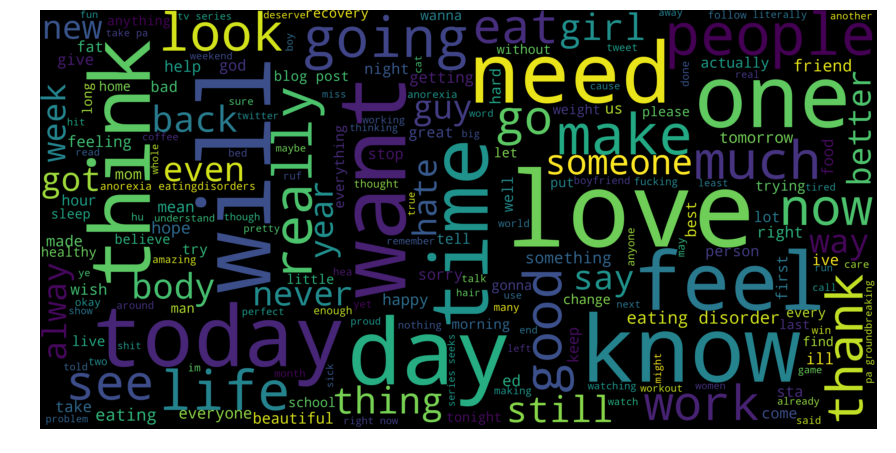

In [343]:
wordcloud_string = ''
for i in range(analysed_users.shape[0]):
    wordcloud_string += analysed_users.iloc[i].processed_text

wordcloud = WordCloud(width=4000, height=2000,max_font_size=500).generate(wordcloud_string)
plot.figure(figsize=(15,12))
plot.imshow(wordcloud, interpolation="bilinear")
plot.axis("off")
plot.show()

wordcloud.to_file("wordcloud.png")

# Topic Modeling on Tweets

In [344]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(stop_words='english')
tfidf_result = vec.fit_transform(analysed_users.processed_text)
feature_names = vec.get_feature_names()

tfidf_result.shape

(39563, 17550)

In [345]:
def top_n(tfidf_result, feature_names, top=100):
        if feature_names is None or tfidf_result is None:
            return

        scores = zip(feature_names,
                     np.asarray(tfidf_result.sum(axis=0)).ravel())

        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

        labels, scores = [], []

        # Get the scores and labels of the top 100 tweets
        for item in sorted_scores[:top]:
            print("{0:50} Score: {1}".format(item[0], item[1]))
            # sns.distplot(item[1], label=item[0])
            labels.append(item[0])
            scores.append(item[1])

        index = np.arange(len(scores))
        plot.bar(index, scores, figure=plot.figure(figsize=(25, 10)))
        plot.xlabel('Word', fontsize=24)
        plot.ylabel('TFIDF Score', fontsize=24)
        plot.xticks(index, labels, fontsize=12, rotation=90)
        plot.title('Top {} features'.format(top))
        plot.savefig('Top_{}'.format(top))

just                                               Score: 554.8983450109803
love                                               Score: 542.7894180406174
like                                               Score: 451.7706359116114
news                                               Score: 431.6653714729475
thank                                              Score: 377.70360092261336
good                                               Score: 354.9831552011154
thanks                                             Score: 354.0287334503386
day                                                Score: 336.3843126202682
want                                               Score: 321.2234869803014
know                                               Score: 316.7227351318119
people                                             Score: 294.8127665272782
need                                               Score: 292.75442505942453
feel                                               Score: 289.3945000763951
today     

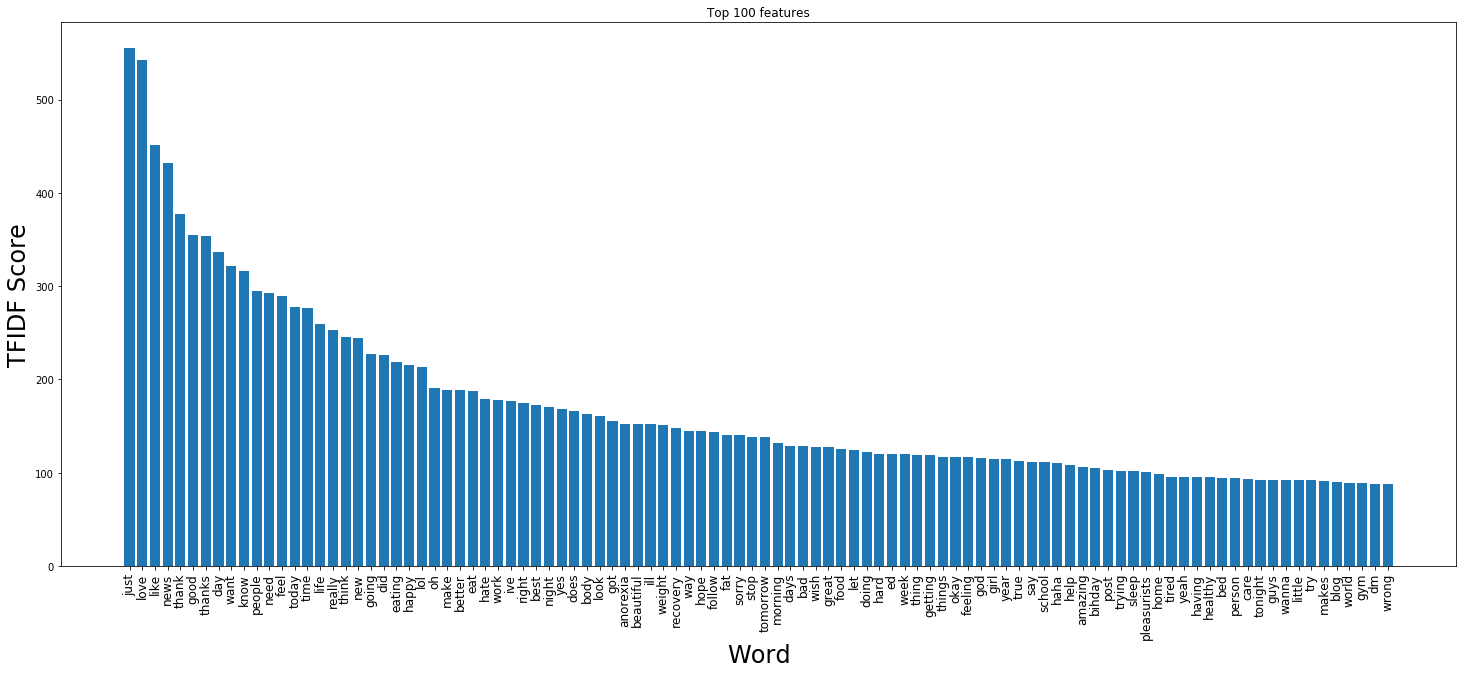

In [346]:
top_n(tfidf_result, feature_names, top=100)

In [363]:
# Topic Modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

num_topics = 5

lda_model = LatentDirichletAllocation(n_topics=num_topics, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(tfidf_result)
print('LDA shape: ')
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=num_topics)
nmf_Z = nmf_model.fit_transform(tfidf_result)
print('NMF shape: ')
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=num_topics)
lsi_Z = lsi_model.fit_transform(tfidf_result)
print('LSI shape: ')
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)


/Users/jtsui/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LDA shape: 
(39563, 5)
NMF shape: 
(39563, 5)
LSI shape: 
(39563, 5)


In [364]:
def print_topics(model, top_n=10):
        for idx, topic in enumerate(model.components_):
            print("Topic %d:" % (idx))
            print([(vec.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]])

In [365]:
# Let's see how the first document in the corpus looks like in different topic spaces
print("LDA Model:")
print("=" * 20)
print_topics(lda_model)
print("=" * 20, '\n')

print("NMF Model:")
print("=" * 20)
print_topics(nmf_model)
print("=" * 20, '\n')

print("LSI Model:")
print("=" * 20)
print_topics(lsi_model)
print("=" * 20, '\n')

LDA Model:
Topic 0:
[('thank', 385.767888700987), ('news', 290.88926964280944), ('work', 216.5447633497069), ('happy', 209.98356174095363), ('oh', 196.59964688316592), ('anorexia', 178.3773419976922), ('tomorrow', 154.00902533115166), ('help', 124.29972228786394), ('things', 120.46341429204594), ('say', 115.58609342862586)]
Topic 1:
[('thanks', 404.4233726053383), ('good', 354.72549914461484), ('like', 191.4049791182838), ('night', 171.36266514384852), ('life', 168.6967552175967), ('hope', 167.73629348831062), ('day', 159.37339447747627), ('just', 157.3296506337781), ('going', 154.174305656796), ('feel', 151.59711874914552)]
Topic 2:
[('yes', 179.86331101110846), ('follow', 178.36552444930584), ('ill', 169.5534937100474), ('better', 132.8234832118981), ('healthy', 120.1691881622637), ('does', 100.15113805292319), ('coffee', 84.44817082100543), ('believe', 83.48215229902073), ('people', 76.33823957879352), ('twye', 75.97251137152826)]
Topic 3:
[('love', 372.7862596467325), ('need', 316.

### Add "follows_professional_sg" and "follows_sg" column to analysed_users

In [350]:
analysed_users["follows_sg"] = False
t = list(user_info[user_info["follows_sg"] == True]["screen_name"])
analysed_users.loc[analysed_users["tweeter_screen_name"].isin(t), "follows_sg"] = True

analysed_users["follows_professional_sg"] = False
t = list(user_info[user_info["follows_professional_sg"] == True]["screen_name"])
analysed_users.loc[analysed_users["tweeter_screen_name"].isin(t), "follows_professional_sg"] = True

analysed_users.head()

,index,created_at,entities,id,in_reply_to_status_id,in_reply_to_user_id,text,truncated,tweeter_id,tweeter_screen_name,...,pos,neg,neu,compound_np,pos_np,neg_np,neu_np,follows_sg,follows_professional_sg,is_support
0,0,2018-10-16 22:35:35,"{'hashtags': [], 'symbols': [], 'user_mentions...",1052327221975748608,NaN,NaN,Whenever I talk negatively about my recovering...,False,41652445,HanBaNannz,...,0.194,0.087,0.720,0.7778,0.194,0.087,0.720,False,False,False
1,2,2018-10-15 23:10:30,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051973619193208832,NaN,NaN,RT @Dame_Lillard: Rock bottom will teach you l...,False,41652445,HanBaNannz,...,0.248,0.000,0.752,0.5106,0.216,0.000,0.784,False,False,False
2,3,2018-10-15 19:20:00,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051915611675287555,NaN,NaN,RT @PatMcAfeeShow: White folks https://t.co/Bu...,False,41652445,HanBaNannz,...,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,False,False
3,4,2018-10-14 19:36:01,"{'hashtags': [{'text': 'LittleSister', 'indice...",1051557254464450562,NaN,NaN,RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...,False,41652445,HanBaNannz,...,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,False,False
4,5,2018-10-14 16:43:27,"{'hashtags': [{'text': 'ConnerStrong', 'indice...",1051513828079480834,NaN,NaN,RT @BleacherReport: Two cancer survivors share...,False,41652445,HanBaNannz,...,0.162,0.324,0.515,-0.4939,0.125,0.250,0.625,False,False,False


In [351]:
yays = analysed_users[(analysed_users['follows_sg'] == True) | (analysed_users['follows_professional_sg'] == True)]  
yays.reset_index(inplace=True)
yays_i = np.random.choice(yays.shape[0],2000)
df1 = yays.loc[yays_i]

nays = analysed_users[(analysed_users.follows_sg == False) & (analysed_users.follows_professional_sg == False)]
nays.reset_index(inplace=True)
nays_i = np.random.choice(nays.shape[0],2000)
df2 = nays.loc[nays_i]


In [352]:
pd.concat([df1,df2]).head()

,level_0,index,created_at,entities,id,in_reply_to_status_id,in_reply_to_user_id,text,truncated,tweeter_id,...,pos,neg,neu,compound_np,pos_np,neg_np,neu_np,follows_sg,follows_professional_sg,is_support
19008,36810,49050,2009-09-22 00:49:44,"{'hashtags': [], 'symbols': [], 'user_mentions...",4160312320,NaN,NaN,ate spinach/spray butter/salt. feeling down to...,False,52289527,...,0.081,0.000,0.919,0.6739,0.246,0.000,0.754,True,True,True
10078,23123,33246,2015-01-18 22:56:54,"{'hashtags': [{'text': 'CBBPerez', 'indices': ...",556948372243087360,NaN,NaN,Perez is evil 👿 #CBBPerez,False,198978269,...,0.000,0.562,0.438,-0.8271,0.000,0.562,0.438,True,True,True
19080,36882,49122,2009-09-08 23:24:32,"{'hashtags': [], 'symbols': [], 'user_mentions...",3851127218,NaN,NaN,now i'm looking at local restaurant menus onli...,False,52289527,...,0.000,0.252,0.748,-0.5719,0.000,0.252,0.748,True,True,True
8635,18453,28029,2013-08-07 16:49:14,"{'hashtags': [], 'symbols': [], 'user_mentions...",365152664083890176,NaN,NaN,@Belle_of_BallSC love you times infinity^infin...,False,1544668758,...,0.583,0.000,0.417,0.6369,0.512,0.000,0.488,True,False,True
5544,12341,21767,2013-07-20 21:44:50,"{'hashtags': [], 'symbols': [], 'user_mentions...",358704076801843200,NaN,NaN,I had to eat at a restaurant today. All I want...,False,1606348873,...,0.048,0.282,0.670,-0.7404,0.048,0.282,0.670,True,True,True


In [353]:
nays.head()

,level_0,index,created_at,entities,id,in_reply_to_status_id,in_reply_to_user_id,text,truncated,tweeter_id,...,pos,neg,neu,compound_np,pos_np,neg_np,neu_np,follows_sg,follows_professional_sg,is_support
0,0,0,2018-10-16 22:35:35,"{'hashtags': [], 'symbols': [], 'user_mentions...",1052327221975748608,NaN,NaN,Whenever I talk negatively about my recovering...,False,41652445,...,0.194,0.087,0.720,0.7778,0.194,0.087,0.720,False,False,False
1,1,2,2018-10-15 23:10:30,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051973619193208832,NaN,NaN,RT @Dame_Lillard: Rock bottom will teach you l...,False,41652445,...,0.248,0.000,0.752,0.5106,0.216,0.000,0.784,False,False,False
2,2,3,2018-10-15 19:20:00,"{'hashtags': [], 'symbols': [], 'user_mentions...",1051915611675287555,NaN,NaN,RT @PatMcAfeeShow: White folks https://t.co/Bu...,False,41652445,...,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,False,False
3,3,4,2018-10-14 19:36:01,"{'hashtags': [{'text': 'LittleSister', 'indice...",1051557254464450562,NaN,NaN,RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...,False,41652445,...,0.000,0.000,1.000,0.0000,0.000,0.000,1.000,False,False,False
4,4,5,2018-10-14 16:43:27,"{'hashtags': [{'text': 'ConnerStrong', 'indice...",1051513828079480834,NaN,NaN,RT @BleacherReport: Two cancer survivors share...,False,41652445,...,0.162,0.324,0.515,-0.4939,0.125,0.250,0.625,False,False,False


In [354]:
analysed_users.shape

(39563, 22)

# Visualizing sentiment distribution

All graphs on the left are those who DO NOT follow support groups, and on the right are those who DO follow support groups. Additionally, the blue bars represent sentiment from our unprocessed data, and orange sentiment comes from our processed data. In all histograms, I filtered out the examples where the sentiment == 0, since those are guaranteed noisy tweets.

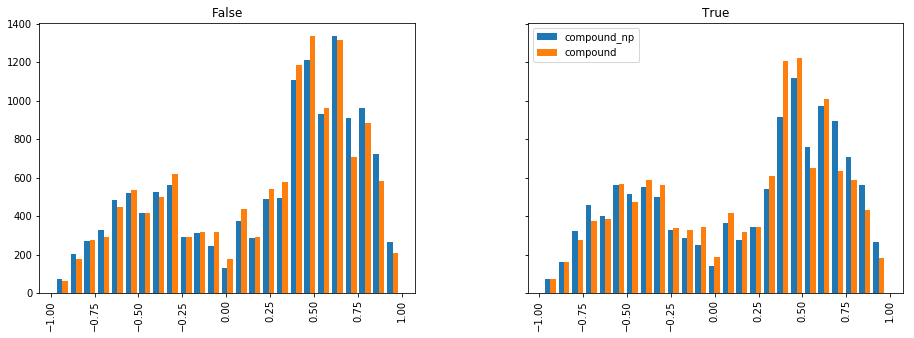

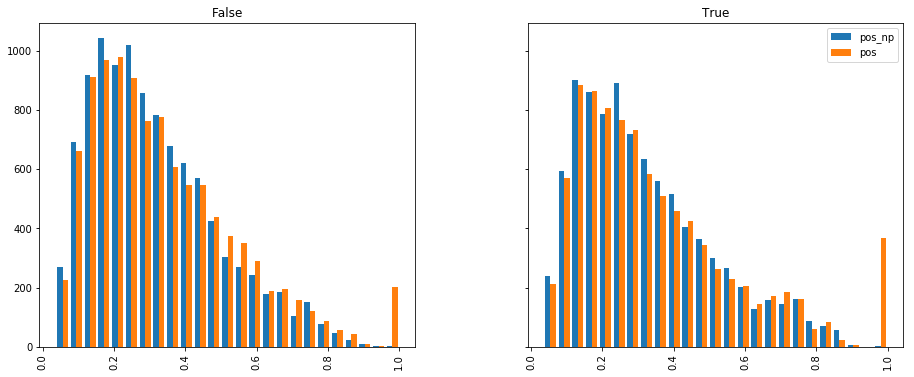

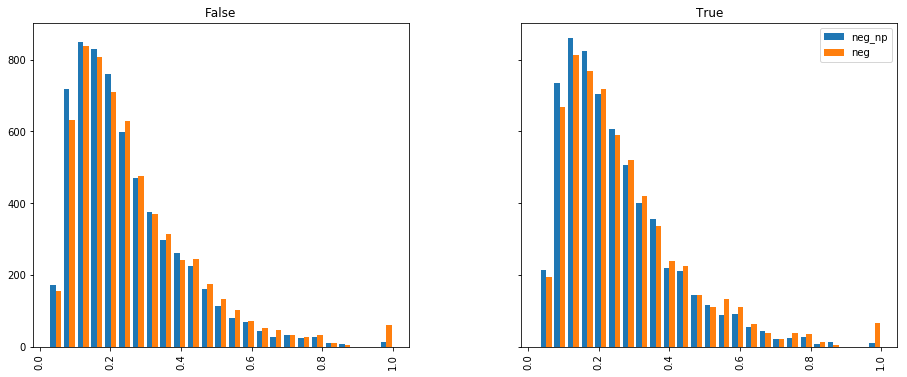

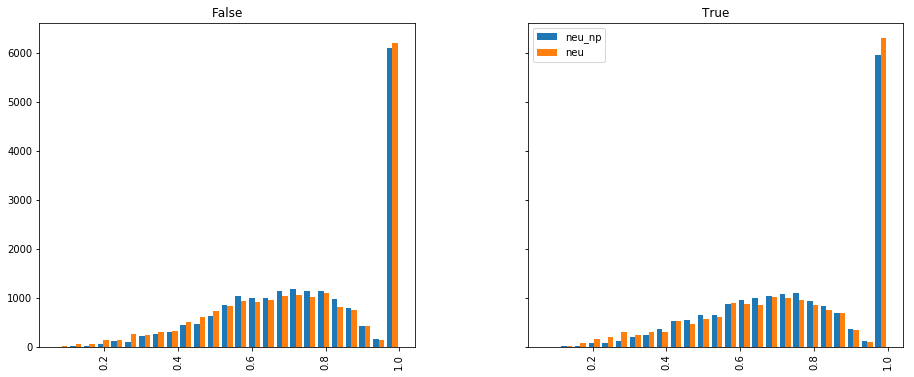

In [426]:
analysed_users['is_support'] = (analysed_users['follows_sg'] == True) | (analysed_users['follows_professional_sg'] == True)
analysed_users.loc[(analysed_users['compound_np'] != 0) & (analysed_users['compound'] != 0)][['compound_np','compound']].hist(bins=25, by=analysed_users['is_support'],figsize=(15,5), sharex=True, sharey=True)
plot.legend(['compound_np', 'compound'])
analysed_users.loc[(analysed_users['pos_np'] != 0) & (analysed_users['pos'] != 0)][['pos_np','pos']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
plot.legend(['pos_np', 'pos'])
analysed_users.loc[(analysed_users['neg_np'] != 0) & (analysed_users['neg'] != 0)][['neg_np','neg']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
plot.legend(['neg_np', 'neg'])
analysed_users.loc[(analysed_users['neu_np'] != 0) & (analysed_users['neu'] != 0)][['neu_np','neu']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
plot.legend(['neu_np', 'neu'])

In [356]:
np.unique(analysed_users.is_support, return_counts=True)

(array([False,  True]), array([20233, 19330]))

In [357]:
cols = ['compound', 'pos', 'neg', 'neu']
cols_np = ['compound_np', 'pos_np', 'neg_np', 'neu_np']

In [358]:
analysed_users.shape

(39563, 22)

#### Users with support groups

In [359]:
analysed_users[analysed_users['is_support'] == True][cols].describe()

,compound,pos,neg,neu
count,19330.000000,19330.000000,19330.000000,19330.000000
mean,0.093143,0.168472,0.091168,0.719824
std,0.412220,0.236247,0.162395,0.274153
min,-0.970900,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.563000
50%,0.000000,0.000000,0.000000,0.755000
75%,0.421500,0.278000,0.148000,1.000000
max,0.971900,1.000000,1.000000,1.000000


#### Users without support groups

In [360]:
analysed_users[analysed_users['is_support'] == False][cols].describe()

,compound,pos,neg,neu
count,20233.000000,20233.000000,20233.000000,20233.000000
mean,0.140257,0.178150,0.081942,0.724981
std,0.424074,0.224987,0.153693,0.256333
min,-0.970000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.562000
50%,0.000000,0.093000,0.000000,0.752000
75%,0.492700,0.307000,0.125000,1.000000
max,0.985400,1.000000,1.000000,1.000000


#### Users without support groups

In [361]:
analysed_users.loc[(analysed_users['is_support'] == True) & (analysed_users['compound_np'] !=0) & (analysed_users['compound'] !=0) ][['compound_np','compound']].describe()

,compound_np,compound
count,12268.000000,12268.000000
mean,0.164368,0.144691
std,0.528819,0.504611
min,-0.974400,-0.970900
25%,-0.341200,-0.320750
50%,0.361200,0.318200
75%,0.612400,0.557400
max,0.972500,0.971900


#### Users with support groups

In [362]:
analysed_users.loc[(analysed_users['is_support'] == False) & (analysed_users['compound_np'] !=0) & (analysed_users['compound'] !=0) ][['compound_np','compound']].describe()

,compound_np,compound
count,13458.000000,13458.000000
mean,0.225340,0.209814
std,0.519683,0.502872
min,-0.973200,-0.970000
25%,-0.273200,-0.250000
50%,0.401900,0.361200
75%,0.636900,0.612400
max,0.985400,0.985400


# Further digging into sentiment analysis

I've noticed that there are a lot of neutral tweets, and that using VaderSentiment's compound score doesn't classify tweets well.
I aim to explore if we can create a cutoff threshold for the polarity scores to filter out tweets that may be either irrelevant or noisy.
If we look at the histograms above, we can see that even though we cut out scores where sentiment = 0, there are a lot of tweets that have compound scores within the range of [-0.5, +0.5].

I tested out filtering the results based off of compound scores being +/- 0.5 and +/- 0.7, and then applied this strategy for users classified as following and not following support groups

### Analysis on users who follow support groups

In [452]:
num_sg_tweets = len(analysed_users['is_support'] == True)
print(num_sg_tweets)

39563


In [456]:
pd.set_option('display.max_colwidth', -1)
THRESHOLD = 0.7
pos_tweets = analysed_users.loc[(analysed_users['compound_np'] > THRESHOLD) & (analysed_users['compound'] > THRESHOLD) & (analysed_users['is_support'] == True)]
print(len(pos_tweets), "tweets with compound positive threshold = {}".format(THRESHOLD))
print(100 * len(pos_tweets) / num_sg_tweets, "% of sg tweets")
pos_tweets[['compound', 'neg', 'neu', 'pos', 'text']].head(n=10)

1460 tweets with compound positive threshold = 0.7
3.690316710057377 % of sg tweets


,compound,neg,neu,pos,text
4693,0.9001,0.000,0.560,0.440,"RT @EatCleanEq: Good morning love bugs, it's gonna be a beautiful day!\n\nBecause I'm going to make it so🌞🙏"
4742,0.8462,0.059,0.626,0.315,"RT @sIyaapaaa: The bitter truth is that so many people are in love but not together, and so many people are together but not in love."
4753,0.7579,0.000,0.723,0.277,"RT @DelicateDoll123: I just need to pull an 'eat, pray, love' and go find myself on the other side of the world."
4767,0.8834,0.000,0.570,0.430,RT @FITchocolate: Loving your physical flaws is a powerful thing. Take time to appreciate your imperfections instead of wishing they didn't…
4781,0.7579,0.000,0.723,0.277,RT @lets_get_tough: opting for lunch at a 100% vegan/gluten free place with a friend I only see every couple of months instead of going to …
4890,0.7351,0.000,0.604,0.396,RT @Buffyshots: @ifbbmissyfarrell: From international cheerleader to IFBB FITNESS PRO! 👋 #notevenshreddedyet #watchout #ifbb #che... http:/…
4893,0.7650,0.000,0.732,0.268,RT @Buffyshots: burn-it-2-earn-it: Love seeing new gains! My back has always been one of the hardest areas for me to build. Chan... http://…
4927,0.7956,0.000,0.647,0.353,RT @NokyFan: “@TheWorldStories: A little thought and a little kindness are often worth more than a great deal of money. http://t.co/6ypuOHI…
4946,0.8625,0.000,0.294,0.706,RT @building_upbabe: Good morning ☺️ Happy rest day! http://t.co/673aipPoHQ
4956,0.7650,0.000,0.761,0.239,RT @PinkHulkk: I upped my flat bench press by 5kg as well; got 15 full reps on 30kg! \n\nMight not seem much but I'm one happy hulk!


In [457]:
THRESHOLD = 0.5
pos_tweets = analysed_users.loc[(analysed_users['compound_np'] > THRESHOLD) & (analysed_users['compound'] > THRESHOLD) & (analysed_users['is_support'] == True)]
print(len(pos_tweets), "tweets with compound positive threshold = {}".format(THRESHOLD))
print(100 *len(pos_tweets) / num_sg_tweets, "% of sg tweets")
pos_tweets[['compound', 'neg', 'neu', 'pos', 'text']].head(n=10)

3419 tweets with compound positive threshold = 0.5
8.641912898415185 % of sg tweets


,compound,neg,neu,pos,text
2589,0.5909,0.185,0.597,0.218,"RT @posichocolate: You've fought a lot of hard battles this week, but you made it through. I'm so proud of you❤️"
2591,0.6948,0.000,0.829,0.171,"RT @posistrawberry: The world is so wonderful!! You have every reason to be here, you are full of worth!! Without you, it would not be the…"
2596,0.6486,0.000,0.654,0.346,"RT @posichocolate: As long as you try your best, that's all that matters"
4654,0.8126,0.000,0.486,0.514,#be at peace with yourself #recovery #letting go #beautiful http://t.co/7j7JqMAPq6
4660,0.7650,0.000,0.431,0.569,#free #be free #beach #eatingdisorders #recovery #liveyourlife http://t.co/ZB9di1Q3oT
4693,0.9001,0.000,0.560,0.440,"RT @EatCleanEq: Good morning love bugs, it's gonna be a beautiful day!\n\nBecause I'm going to make it so🌞🙏"
4695,0.5859,0.000,0.513,0.487,@emily_the_ox @softball_fit wow how did u do that?
4714,0.6115,0.000,0.667,0.333,RT @ayedyIan: i’m so thankful I had a childhood before technology took over
4725,0.8126,0.000,0.519,0.481,RT @SmackFittie: Spending the last day of summer with my best friend&lt;3
4726,0.6369,0.000,0.769,0.231,"Speaking of high carb vegan, im in love with this juice!!! Apple and mango delish!! http://t.co/v3W4iG6CsZ"


In [458]:
pd.set_option('display.max_colwidth', -1)
THRESHOLD = -0.7
neg_tweets = analysed_users.loc[(analysed_users['compound_np'] < THRESHOLD) & (analysed_users['compound'] < THRESHOLD) & (analysed_users['is_support'] == True)]
print(len(neg_tweets), "tweets with compound negative threshold = {}".format(THRESHOLD))
print(100 * len(neg_tweets) / num_sg_tweets, "% of sg tweets")
neg_tweets[['compound', 'neg', 'neu', 'pos', 'text']].head(n=10)

615 tweets with compound negative threshold = -0.7
1.5544827237570458 % of sg tweets


,compound,neg,neu,pos,text
4694,-0.7133,0.229,0.771,0.000,"RT @6nxiety: you've become so damaged that when someone tries to give you what deserve, you have no fucking idea how to respond"
4706,-0.7184,0.667,0.333,0.000,RT @girlWhoIsDead: shit I messed up big time...
4741,-0.8780,0.461,0.539,0.000,"RT @StuffKaySays_: I'm incredibly sick, incredibly confused, and incredibly stressed. I'm not sure how things could get much worse😰"
4774,-0.7178,0.545,0.455,0.000,@this_is_mee__ you might have cancer? I'm so sorry x
4798,-0.7845,0.475,0.404,0.121,"RT @Inn2Fitness: Warning: Living a healthy lifestyle will only deprive you of poor health, fatigue, and fat."
4802,-0.7862,0.265,0.735,0.000,"RT @kellayrene: I don't care who you are, or what you're posting. If you use the wrong 'your', 'there', or 'to', I wince and stop reading t…"
4826,-0.7096,0.371,0.629,0.000,"@fitlittlefox no insanity has 8 different dvds, 4 for the first 30 days n 4 for the other 30"
4843,-0.9442,0.641,0.359,0.000,RT @suicidexsadness: sadly enough my life is all about;\ncutting | purging | starving | suicidal thoughts | suicidal attempts.
4851,-0.7967,0.337,0.663,0.000,"RT @sadxnesss: if nothing turns good by the end of this school year, I'm going to kill myself."
4873,-0.9686,0.630,0.370,0.000,RT @ImAnasGirl: I'm cold \nI'm scared \nI'm worried \nI'm hurting \nI'm broken \nI'm suicidal \nI'm insane \nI'm mental \nI'm failing \nI'm stupid \n…


In [459]:
THRESHOLD = -0.5
neg_tweets = analysed_users.loc[(analysed_users['compound_np'] < THRESHOLD) & (analysed_users['compound'] < THRESHOLD) & (analysed_users['is_support'] == True)]
print(len(neg_tweets), "tweets with compound negative threshold = {}".format(THRESHOLD))
print(100 * len(neg_tweets) / num_sg_tweets, "% of sg tweets")
neg_tweets[['compound', 'neg', 'neu', 'pos', 'text']].head(n=10)

1745 tweets with compound negative threshold = -0.5
4.4106867527740565 % of sg tweets


,compound,neg,neu,pos,text
2595,-0.6249,0.459,0.541,0.000,Keep fighting! Fight to get your life back😊
2598,-0.6124,0.302,0.644,0.054,"Keep fighting no matter how hard things get, there is light at the end of the tunnel!"
4674,-0.5267,0.129,0.871,0.000,"""The loneliest moment in someone's life is when they are watching their whole world fall apart, and all they can do is stare blankly""Gatsby"
4690,-0.5267,0.141,0.806,0.053,RT @cr0sstheline: Cross the line if you thought you were okay but now you keep breaking down &amp; you can't talk to anyone about how scared yo…
4694,-0.7133,0.229,0.771,0.000,"RT @6nxiety: you've become so damaged that when someone tries to give you what deserve, you have no fucking idea how to respond"
4696,-0.6908,0.289,0.711,0.000,RT @countryfitt_: I've spent roughly $165 in the last month just by eating out.... Gotta cut that shit out🙅
4706,-0.7184,0.667,0.333,0.000,RT @girlWhoIsDead: shit I messed up big time...
4734,-0.6908,0.610,0.390,0.000,RT @PoetryPix: How to murder someone: http://t.co/8wzyJvrY48
4741,-0.8780,0.461,0.539,0.000,"RT @StuffKaySays_: I'm incredibly sick, incredibly confused, and incredibly stressed. I'm not sure how things could get much worse😰"
4743,-0.5106,0.171,0.829,0.000,RT @TheFitnessGirls: Your mind will quit 100 times before your body ever does. Feel the pain and do it anyway.


### Analysis on users who DO NOT follow support groups

In [453]:
num_nonsg_tweets = len(analysed_users['is_support'] == False)
print(num_nonsg_tweets)

39563


In [460]:
pd.set_option('display.max_colwidth', -1)
THRESHOLD = 0.7
pos_tweets = analysed_users.loc[(analysed_users['compound_np'] > THRESHOLD) & (analysed_users['compound'] > THRESHOLD) & (analysed_users['is_support'] == False)]
print(len(pos_tweets), "tweets with compound positive threshold = {}".format(THRESHOLD))
print(100 * len(pos_tweets) / num_nonsg_tweets, "% of non sg tweets")
pos_tweets[['compound', 'neg', 'neu', 'pos', 'text']].head(n=10)

2076 tweets with compound positive threshold = 0.7
5.247327047999393 % of non sg tweets


,compound,neg,neu,pos,text
0,0.7778,0.087,0.720,0.194,"Whenever I talk negatively about my recovering body, Brandon responds with ""I love your body and think you're the most beautiful woman I've ever seen."" I have no doubt that God put this man in my life for a reason. He lifts me up on a daily basis."
6,0.7351,0.090,0.571,0.338,RT @SportsCenter: Impressive start to the night for @obj 😂\n\n📺: NFL Network #PHIvsNYG \nhttps://t.co/fqVfJvkGyC
16,0.8807,0.000,0.000,1.000,@hntrevino Yay! Yay! Yay!
18,0.7691,0.066,0.667,0.268,"RT @CrewKyli: ladies if you’re reading this, I pray that one day you find a man who loves you so much you forget what it feels like to be h…"
21,0.9001,0.066,0.587,0.347,"I spent the day in one of my favorite cites with the man I love looking at beautiful art. This is why I continue to fight, for priceless days like today. #anorexiarecovery"
32,0.8122,0.000,0.763,0.237,"Exactly one month ago, I was being admitted to the cardiac floor at Sparrow and was days from dying. Today, I will celebrate with an incredibly grateful heart and lots of food."
33,0.7184,0.000,0.600,0.400,@ZSBarrick I volunteer to be your taste tester 😊
41,0.8625,0.000,0.534,0.466,Currently enjoying a huge ice cream cone while chatting with a complete stranger. Life is beautiful.
51,0.9017,0.000,0.675,0.325,"I'm at the Lions game with the two men I love most and honestly, I can't remember when my heart has been this filled with happiness. 💙"
57,0.8402,0.092,0.496,0.411,"RT @Dictionarycom: Class is defined as informal. elegance, grace, or dignity. \n\nSee also: Serena Williams after Naomi Osaka's Grand Slam wi…"


In [461]:
THRESHOLD = 0.5
pos_tweets = analysed_users.loc[(analysed_users['compound_np'] > THRESHOLD) & (analysed_users['compound'] > THRESHOLD) & (analysed_users['is_support'] == False)]
print(len(pos_tweets), "tweets with compound positive threshold = {}".format(THRESHOLD))
print(100 * len(pos_tweets) / num_nonsg_tweets, "% of non sg tweets")
pos_tweets[['compound', 'neg', 'neu', 'pos', 'text']].head(n=10)

4725 tweets with compound positive threshold = 0.5
11.942977023987059 % of non sg tweets


,compound,neg,neu,pos,text
0,0.7778,0.087,0.720,0.194,"Whenever I talk negatively about my recovering body, Brandon responds with ""I love your body and think you're the most beautiful woman I've ever seen."" I have no doubt that God put this man in my life for a reason. He lifts me up on a daily basis."
1,0.5106,0.000,0.752,0.248,RT @Dame_Lillard: Rock bottom will teach you lessons that mountain tops never will...
5,0.6808,0.000,0.588,0.412,RT @MSU_Football: This marks @DantonioMark's 10th win over an AP Top 10 team. #GoGreen
6,0.7351,0.090,0.571,0.338,RT @SportsCenter: Impressive start to the night for @obj 😂\n\n📺: NFL Network #PHIvsNYG \nhttps://t.co/fqVfJvkGyC
8,0.5994,0.000,0.000,1.000,@jgove77 Congratulations!!
9,0.6369,0.141,0.449,0.410,RT @Ketnipz: A friendly reminder to be kinder to no.1 on #WorldMentalHealthDay ❤️🧠 https://t.co/v8LHkDa9bx
15,0.5267,0.000,0.732,0.268,I firmly believe that I would make a better football coach than Brandon. His defense is garbage.
16,0.8807,0.000,0.000,1.000,@hntrevino Yay! Yay! Yay!
18,0.7691,0.066,0.667,0.268,"RT @CrewKyli: ladies if you’re reading this, I pray that one day you find a man who loves you so much you forget what it feels like to be h…"
19,0.6369,0.000,0.679,0.321,RT @CadynAlexis: I wish there was a way to make Siri sound like Schmidt from New Girl


In [462]:
pd.set_option('display.max_colwidth', -1)
THRESHOLD = -0.7
neg_tweets = analysed_users.loc[(analysed_users['compound_np'] < THRESHOLD) & (analysed_users['compound'] < THRESHOLD) & (analysed_users['is_support'] == False)]
print(len(neg_tweets), "tweets with compound negative threshold = {}".format(THRESHOLD))
print(100 * len(neg_tweets) / num_nonsg_tweets, "% of non sg tweets")
neg_tweets[['compound', 'neg', 'neu', 'pos', 'text']].head(n=10)

603 tweets with compound negative threshold = -0.7
1.524151353537396 % of non sg tweets


,compound,neg,neu,pos,text
34,-0.8056,0.592,0.408,0.0,People are so rude. It's disgusting.
36,-0.9700,0.661,0.339,0.0,"RT @ChloeAngyal: ""She was drunk, this rape is her fault.""\n\n""He was drunk, this rape isn't his fault."
84,-0.8481,0.506,0.494,0.0,RT @licii98: being uncomfortable w ur body is the worst of the worst
108,-0.8720,0.432,0.568,0.0,You're the worst kind of person if you shame someone for having a mental health disorder.
174,-0.9169,0.398,0.602,0.0,RT @rmayemsinger: You lost me at 17 - 18 year olds are too young to have opinions about guns but old enough to die in wars.
177,-0.7952,0.402,0.598,0.0,RT @nathanielcs: the most gun control we’ve had is apple replacing the gun emoji with a water gun
211,-0.7096,0.269,0.731,0.0,"RT @FullFrontalSamB: Three months ago, you walked out of an event in disgust because of a non-violent protest by black athletes.\nhttps://t.…"
225,-0.7096,0.247,0.753,0.0,RT @keithboykin: Imagine how President Obama felt having to put up with a loudmouth “billionaire” spreading fake news and lies about his bi…
280,-0.7184,0.545,0.455,0.0,RT @BBCOne: Can’t type. Heart broken. 😫 #BluePlanet2 https://t.co/pfEmBqvNHz
333,-0.7717,0.528,0.472,0.0,RT @ajplus: Why are these Antarctic penguins starving to death? https://t.co/3pwUKTyoq3


In [463]:
THRESHOLD = -0.5
neg_tweets = analysed_users.loc[(analysed_users['compound_np'] < THRESHOLD) & (analysed_users['compound'] < THRESHOLD) & (analysed_users['is_support'] == False)]
print(len(neg_tweets), "tweets with compound negative threshold = {}".format(THRESHOLD))
print(100 * len(neg_tweets) / num_nonsg_tweets, "% of non sg tweets")
neg_tweets[['compound', 'neg', 'neu', 'pos', 'text']].head(n=10)

1725 tweets with compound negative threshold = -0.5
4.360134469074641 % of non sg tweets


,compound,neg,neu,pos,text
34,-0.8056,0.592,0.408,0.000,People are so rude. It's disgusting.
36,-0.9700,0.661,0.339,0.000,"RT @ChloeAngyal: ""She was drunk, this rape is her fault.""\n\n""He was drunk, this rape isn't his fault."
55,-0.6887,0.246,0.646,0.109,Brandon just sang to me Perfect by P!nk because I'm really having a bad day. I'm going to marry the hell out of that man someday.
56,-0.5574,0.301,0.588,0.110,Feeling uncomfortable in your own body is the absolute worst.
58,-0.5423,0.259,0.741,0.000,RT @ComplexSports: Should be a crime to evoke this reaction out of Serena tbh https://t.co/kUsZk8sedw
73,-0.6808,0.338,0.662,0.000,leftover birthday cake for breakfast because why the hell not?
84,-0.8481,0.506,0.494,0.000,RT @licii98: being uncomfortable w ur body is the worst of the worst
96,-0.6428,0.378,0.622,0.000,"RT @elianaxox: gwen stefani was right, this shit is bananas"
98,-0.5423,0.368,0.632,0.000,RT @typicaljillll: october get your spooky ass over here
108,-0.8720,0.432,0.568,0.000,You're the worst kind of person if you shame someone for having a mental health disorder.


As you can see, the quality of the tweets drastically improves as we make our threshold more strict. For negative tweets, the content of the tweets becomes much more focused towards the terrors battling Anorexia, and for the positive tweets, they deal more with overcoming anorexia.

# Network Analysis